To read more about embeddings, checkout this [tutorial](https://www.elastic.co/search-labs/tutorials/search-tutorial/vector-search/store-embeddings)

## Connect To ElasticSearch

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'FQt-ffZfTpeh0Snf3pUAQw',
 'name': 'ae8b5b4be42b',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


## Preparing the index

We are adding a new field with type `dense_vector` to store the embeddings.

In [2]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index="my_index",
    mappings={
        "properties":{
            "embedding":{
                "type":"dense_vector",
            }
        }
    }
)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

## Embedding model

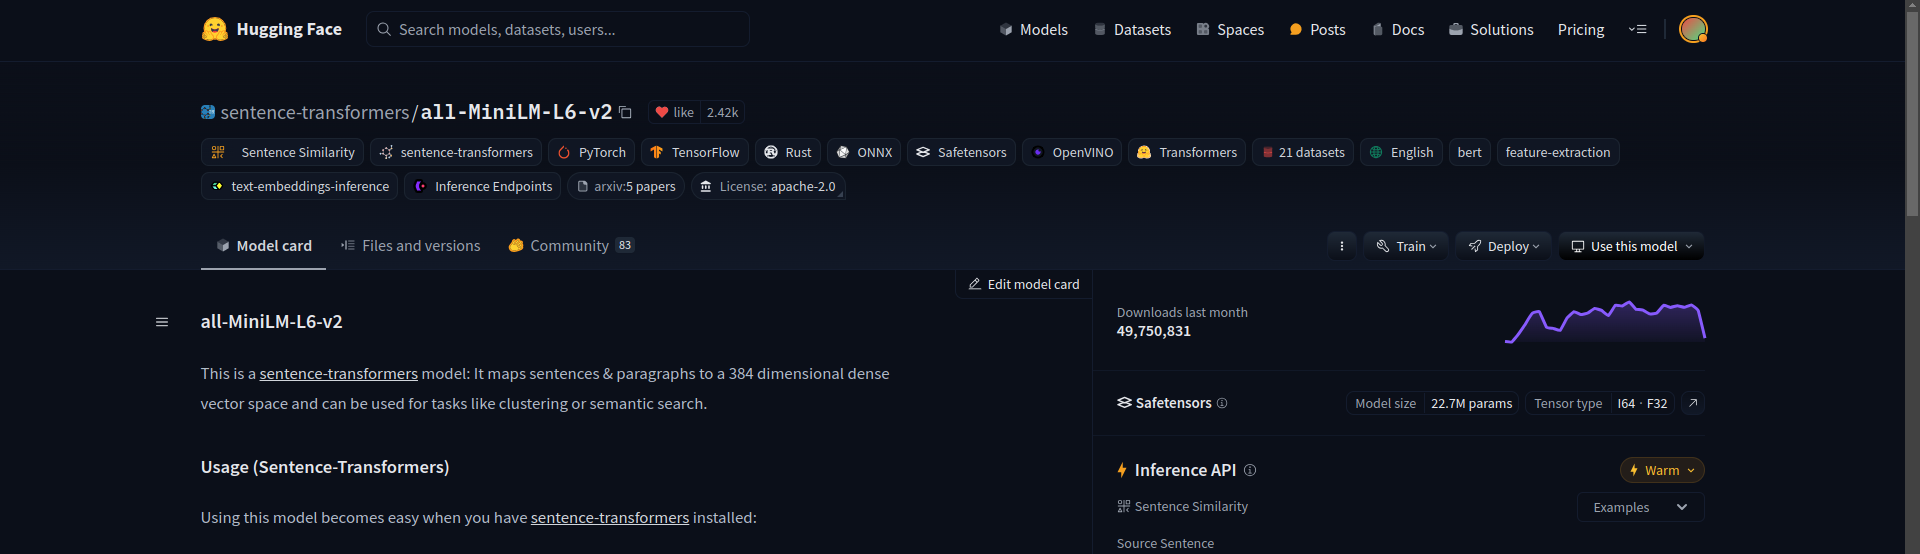

In [3]:
from IPython.display import Image, display

display(Image(filename="../images/all-MiniLM-L6-v2_model.png"))

I chose the a`ll-MiniLM-L6-v2` model for its speed, compact size, and versatility as a general-purpose model. It features an embedding dimension of `384` and truncates text that exceeds `256` words. This model is very popular in the community with almost `50M` downloads in one month.

To download and utilize this model, Hugging Face offers a Python package called `sentence-transformers`. This framework simplifies the process of computing dense vector representations.

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
model = model.to(device)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Load Document

In [7]:
import json

documents = json.load(open("../data/dummy_data.json"))
documents

[{'title': 'Sample Title 1',
  'text': 'This is the first sample document text.',
  'created_on': '2024-09-22'},
 {'title': 'Sample Title 2',
  'text': 'Here is another example of a document.',
  'created_on': '2024-09-24'},
 {'title': 'Sample Title 3',
  'text': 'The content of the third document goes here.',
  'created_on': '2024-09-24'}]

## Embed Document

In [8]:
from tqdm import tqdm
from pprint import pprint


def get_embedding(text):
    return model.encode(text)


operations = []
for document in tqdm(documents, total=len(documents)):
    operations.append({'index': {'_index': 'my_index'}})
    operations.append({
        **document,
        'embedding': get_embedding(document['text']),
    })

response = es.bulk(operations=operations)
pprint(response.body)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 103.58it/s]

{'errors': False,
 'items': [{'index': {'_id': 'QLFXSJoBesPIpDe2hUs_',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'QbFXSJoBesPIpDe2hUtA',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'QrFXSJoBesPIpDe2hUtA',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

We indexed all documents with an additional field `embedding`. Let's retrieve the documents to verify that the text was converted to a dense vector.

In [9]:
response = es.search(
    index='my_index',
    body={
        "query":{
            "match_all":{}
        }
    }
)

pprint(response["hits"]["hits"])

[{'_id': 'QLFXSJoBesPIpDe2hUs_',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'created_on': '2024-09-22',
              'embedding': [-0.04355234280228615,
                            0.06440843641757965,
                            -0.005080216098576784,
                            0.03445182740688324,
                            0.040633425116539,
                            0.01460320595651865,
                            -0.019641758874058723,
                            0.049041084945201874,
                            0.035828862339258194,
                            0.011970632709562778,
                            0.04181128367781639,
                            0.0825410932302475,
                            -0.00032648746855556965,
                            -0.03726024180650711,
                            -0.009786712937057018,
                            0.039124757051467896,
                            0.0309367086738348,
                            -0.07445882

Awesome! We successfully inserted the documents with the additional `embedding` field. Now, let’s check the mapping to confirm that the dimension of the dense vector is 384.

In [10]:
response = es.indices.get_mapping(index='my_index')
pprint(response.body)

{'my_index': {'mappings': {'properties': {'created_on': {'type': 'date'},
                                          'embedding': {'dims': 384,
                                                        'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'},
                                          'text': {'fields': {'keyword': {'ignore_above': 256,
                                                                          'type': 'keyword'}},
                                                   'type': 'text'},
                                          'title': {'fields': {'keyword': {'ignore_above':